In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoModel
from PIL import Image

In [4]:
def coords_grid(b, h, w, homogeneous=False, device=None):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w))  # [H, W]

    stacks = [x, y]

    if homogeneous:
        ones = torch.ones_like(x)  # [H, W]
        stacks.append(ones)

    grid = torch.stack(stacks, dim=0).float()  # [2, H, W] or [3, H, W]

    grid = grid[None].repeat(b, 1, 1, 1)  # [B, 2, H, W] or [B, 3, H, W]

    if device is not None:
        grid = grid.to(device)

    return grid

In [5]:
# load model
model = AutoModel.from_pretrained("stevetod/doduo", trust_remote_code=True)

In [6]:
# load image
resize_size = (320, 240)
frame_src = Image.open("../data/imgs_src.png").resize(resize_size)
frame_dst = Image.open("../data/imgs_dst.png").resize(resize_size)

frame1_img = np.array(frame_src)
frame2_img = np.array(frame_dst)

In [7]:
# inference dense correspondence
flow = model(frame_src, frame_dst)
flow_coords = coords_grid(flow.size(0), flow.size(2), flow.size(3)).to(flow.device)
matching = flow + flow_coords
matching = matching[0].long().cpu().numpy()

/home/zhenyu/.cache/huggingface/modules/transformers_modules/stevetod/doduo/f392e77c4cdd1a841745d0f4c06142002e9624cb/position.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/zhenyu/miniconda3/envs/corr-fomo/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


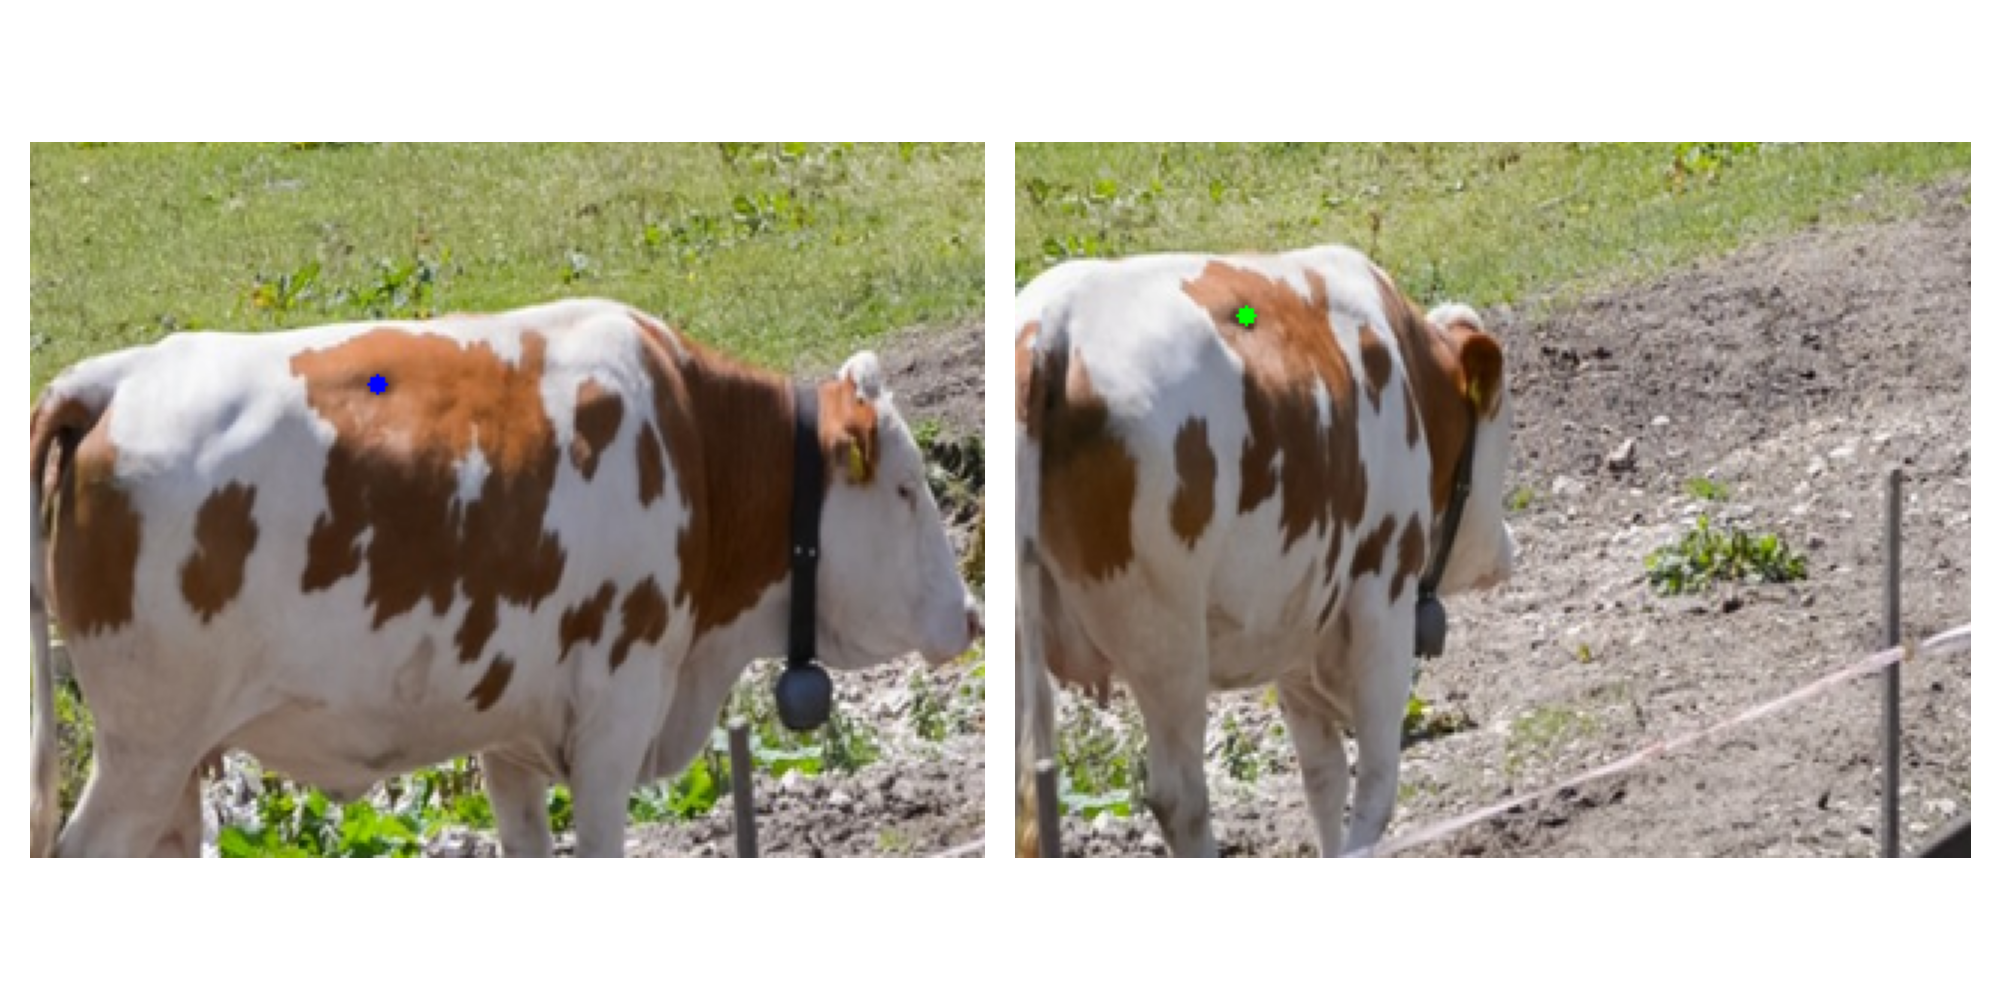

In [8]:
# interactive visualization of correspondence
# click on left image and get corresponding point on the right
%matplotlib nbagg
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(frame1_img)
axs[0].axis("off")
axs[1].imshow(frame2_img)
axs[1].axis("off")

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        frame1_img_mark = cv2.circle(frame1_img.copy(), (x, y), 3, (0, 0, 255), -1)
        max_x, max_y = matching[:, y, x]
        frame2_img_mark = cv2.circle(frame2_img.copy(), (max_x, max_y), 3, (0, 255, 0), -1)
        axs[0].imshow(frame1_img_mark)
        axs[0].axis("off")
        axs[1].imshow(frame2_img_mark)
        axs[1].axis("off")
        plt.draw()

cid = fig.canvas.mpl_connect("button_press_event", onclick)
plt.tight_layout()
plt.show()